In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Problem Statement

The `video_games_data.xlsx` file contains data on video game sales and their corresponding ratings, along with Google Trends web and shopping search data for select titles. In this case study, you are trying to answer the following questions:

1. Can you predict whether a Madden NFL title will break 5 million in unit sales in the U.S. (the `NA_Sales` column) using Google Trends web and shopping search data, platform, critic and user score, number of reviews by critics and users, etc?


2. What is your forecast of total unit sales across all platforms in the U.S. for Madden NFL 16 and Madden NFL 17?

You may perform internet searches for values of existing, but not additional, explanatory variables. In addition to your notebooks or scripts, you may wish to craft a presentation to help convey high-level ideas about your work.

# Video Game Sales

## Exploration and Visualization

In [3]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cb91visuals import *

In [4]:
# Load the data
file_path = 'data/casestudy/video_games_data.xlsx'
sales = pd.read_excel(file_path, sheet_name=2)
sales.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check missing values
print('Number of NaN values in year:', sales['Year_of_Release'].isna().sum())
print('Number of NaN values in title:', sales['Name'].isna().sum())
print()
print('Original size of dataset:', len(sales))
sales.dropna(subset=['Year_of_Release', 'Name'], inplace=True)
print('Size after dropping NaN:', len(sales))

Number of NaN values in year: 269
Number of NaN values in title: 2

Original size of dataset: 16711
Size after dropping NaN: 16440


First, let us observe the general trend of the global annual video game sales:

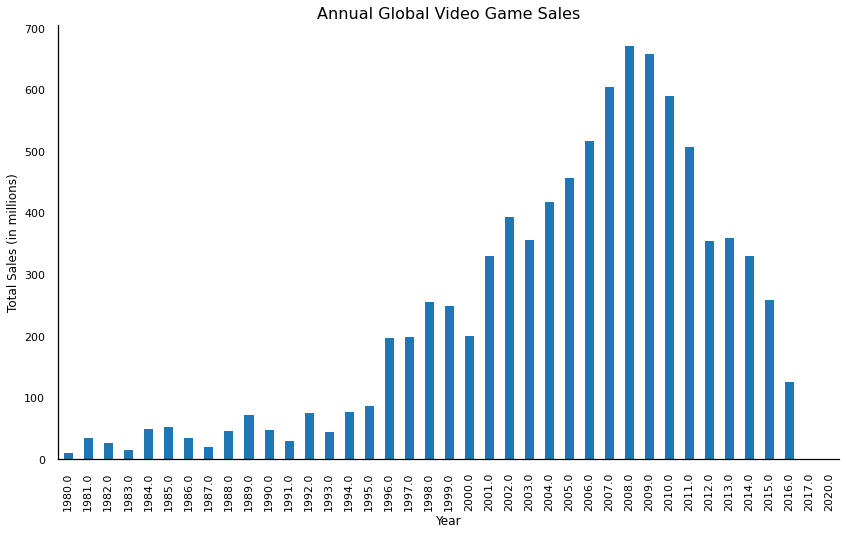

In [6]:
sales.sort_values('Year_of_Release', inplace=True)
annual_global_sales = sales.groupby('Year_of_Release').sum()['Global_Sales']
annual_global_sales.plot(kind='bar', figsize=(14, 8), title='Annual Global Video Game Sales',
                         xlabel='Year', ylabel='Total Sales (in millions)', color='tab:blue')
plt.show()

Video games sales showed a significant upward trend all the way from their early days in the 1980s to the early 2000s. However, there appears to have been a big drop-off from around 2010. Lastly, the latter years lack sufficient data and will likely have to be removed.

In [7]:
n = sales[sales['Year_of_Release'].isin([2017, 2018, 2019, 2020])].count()['Year_of_Release']
print('Number of titles in 2017 to 2020:', n)
sales_truncated = sales[sales['Year_of_Release'] < 2017]

Number of titles in 2017 to 2020: 4


Now I plot the *regional* video game sales:

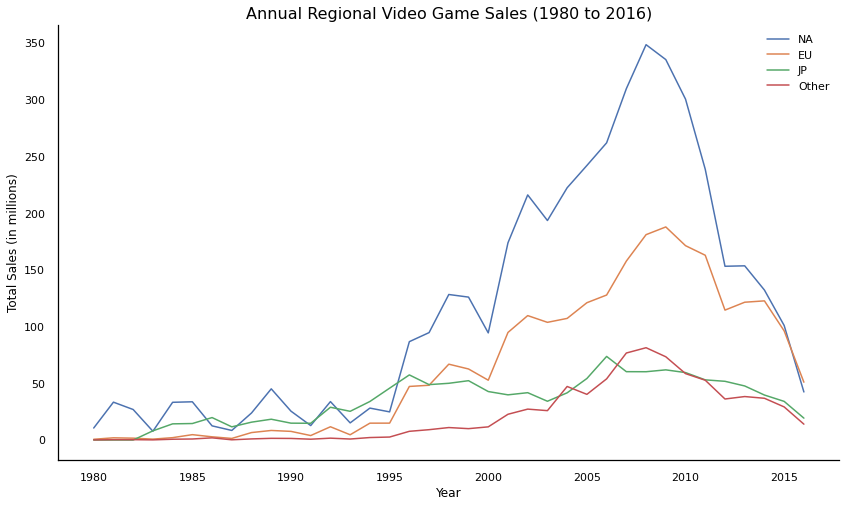

In [8]:
annual_regional_sales = sales_truncated.groupby('Year_of_Release').sum()[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
annual_regional_sales.plot(figsize=(14, 8), title='Annual Regional Video Game Sales (1980 to 2016)',
                           xlabel='Year', ylabel='Total Sales (in millions)')
plt.legend(['NA', 'EU', 'JP', 'Other'])
plt.show()

In the early 2000s, US video game sales had a larger proportional increase than other regions. This could have implications towards answering *Q1)* of this case study. It would also be useful to see how the popularity of certain genres changes over time. To quantify this, I create a measure for visualization. For a given genre, the  *sales per title* is defined as

\begin{equation}
    \text{SPT} = \frac{\text{Total Sales}}{n},
\end{equation}

where $n$ represents the total number of games published in that year. Rather than plotting the absolute sales, a this *normalized* measure provides information on the average number of copies sold for a genre in a given year.

In [9]:
genres = sales_truncated['Genre'].unique()
print('No. of Genres:', len(genres))
print(genres)

No. of Genres: 12
['Misc' 'Fighting' 'Action' 'Shooter' 'Sports' 'Puzzle' 'Platform'
 'Racing' 'Simulation' 'Adventure' 'Role-Playing' 'Strategy']


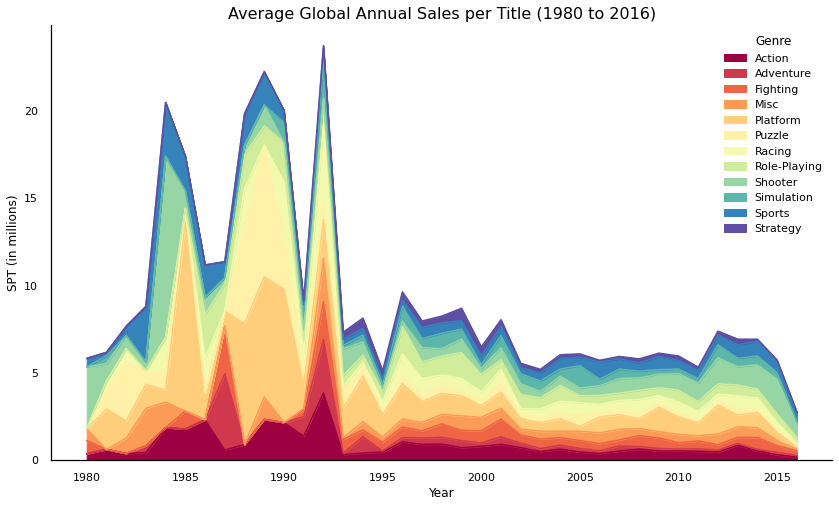

In [22]:
annual_genre_releases = sales_truncated.groupby(['Year_of_Release', 'Genre']).count()['Name']
annual_genre_sales = sales_truncated.groupby(['Year_of_Release', 'Genre']).sum()['Global_Sales']
annual_genre_sales_per_title = annual_genre_sales / annual_genre_releases

annual_genre_sales_per_title.unstack().plot(
    figsize=(14, 8), kind='area', colormap='Spectral', stacked=True,
    title='Average Global Annual Sales per Title (1980 to 2016)',
    xlabel='Year', ylabel='SPT (in millions)')

plt.show()

As there were fewer releases in the 1980s leading up to the 2000s, the *SPT* is extremely high. Notably, Platform and Puzzle games were extremely popular. 

Now I explore the relationship between the User Score and Critic Score.

In [37]:
scores = sales_truncated.dropna(subset=['Critic_Score', 'User_Score'])[['Year_of_Release', 'Critic_Score', 'User_Score', 'Global_Sales']]
scores = scores[scores['User_Score'] != 'tbd']
scores['User_Score'] = scores['User_Score'].astype(float)

print('Number of Scores:', len(scores), '(' + str(round(len(scores) / len(sales) * 100, 2)) + '%)', '\n')

print('Average Critic Score:', scores['Critic_Score'].mean().round(1))
print('Maximum Critic Score:', scores['Critic_Score'].max().round(1))
print('Minimum Critic Score:', scores['Critic_Score'].min().round(1), '\n')

print('Average User Score:', scores['User_Score'].mean().round(1))
print('Maximum User Score:', scores['User_Score'].max().round(1))
print('Minimum User Score:', scores['User_Score'].min().round(1))

Number of Scores: 6890 (41.91%) 

Average Critic Score: 70.3
Maximum Critic Score: 98.0
Minimum Critic Score: 13.0 

Average User Score: 7.2
Maximum User Score: 9.6
Minimum User Score: 0.5


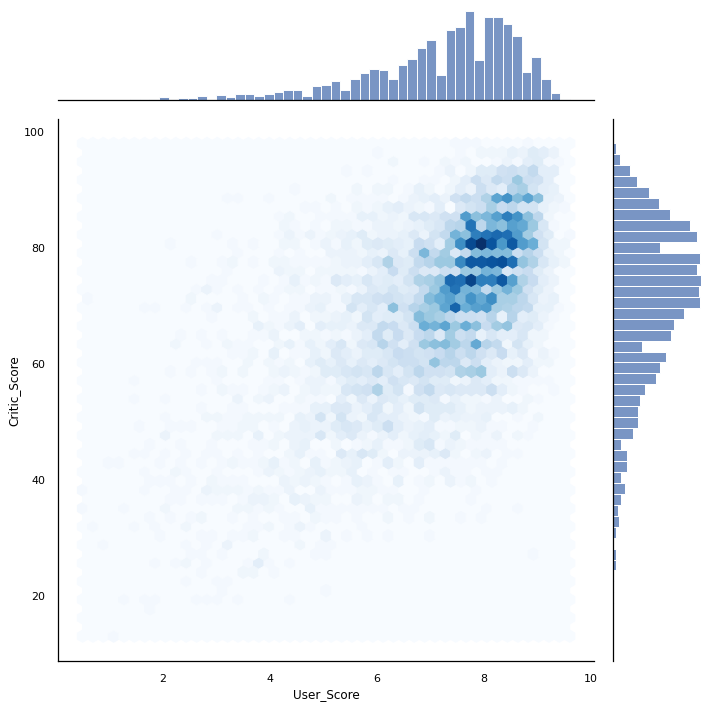

In [34]:
g = sns.jointplot(x="User_Score", y="Critic_Score", data=scores, cmap="Blues", kind="hex", height=10)

## Building a Predictive Model

### Feature Engineering

Each video game title can be indexed by their `Year_of_Release`. However, what are we trying to predict? If we intend to predict the global sales, one of the primary considerations is *look-ahead bias*. The columns contained within the sales data include:

In [84]:
sales = pd.read_excel(file_path, sheet_name=2)

Numbers such as `User_Score` and `User_Count` would not be available prior to a video game's release. On the other hand, the `Critic_Score` would be - critics receive review copies of the games prior to release. Therefore this an be considered as a viable feature.

Categorical features such as `Platform`, `Genre` and `Publisher` must also make an impact on the sales of a video game. The reputation of publishers such as Nintendo would garner greater demand. However, there are too have been numerous *unique* publishers over the years which makes this variable untractable without feature engineering:

In [85]:
print('Number of Unique Publishers:', len(sales['Publisher'].unique()))

Number of Unique Publishers: 582


Encoding this variable using techniques such as One-Hot-Encoding would result in a drastic increase in dimensionality. However, that does not mean that this feature is not useful. Publishers carry with them not just their reputation, but also historical sales success. Therefore, to capture this information, I define and implement a simple measure below. This simply measures the a publisher's mean number of sales per title in the past four years. If no games were released in that period, it takes a value of zero.

In [86]:
# Instead of publisher name, take "Average Global Sales per Game for the Past Four Years"
sales['Publisher_Sales'] = [0.0 for _ in range(len(sales))]
for i in range(len(sales)):
    row = sales.iloc[i]
    pub = row['Publisher']
    year = row['Year_of_Release']
    four_years_before = year - 4.0
    four_year_sales = sales[(sales['Year_of_Release'] >= four_years_before) & (sales['Year_of_Release'] < year) & (sales['Publisher'] == pub)]
    if len(four_year_sales) > 0:
        avg_sales = four_year_sales.mean()['Global_Sales']
        sales.iat[i, -1] = avg_sales

The `Platform` variable also suffers from the same issue, though to a lesser extent:

In [87]:
len(sales['Platform'].unique())

31

Again, to make this slightly more interpretable for the model, I generalize the platforms with the following mappings, *then* I perform one-hot-encoding in the next section.

In [88]:
platform_mappings = {'PS4': 'PS', 'XOne': 'XB', 'WiiU': 'N', '3DS': 'N', 'PSV': 'PS', 'PS3': 'PS', 'X360': 'XB',
                     'PSP': 'PS', 'Wii': 'N', 'DS': 'N', 'PS2': 'PS', 'GC': 'N', 'GBA': 'N'}

Therefore, I selected the following features for the model:

- `Year_of_Release`
- `Genre`
- `Platform`
- `Publisher_Sales` (as defined in the cell above)
- `Critic_Score`

With the following output variable for prediction:

- `NA_Sales`

as we will later attempt to predict the sales of Madden NFL titles in the *U.S.*

In [103]:
df = sales[['Year_of_Release', 'Genre', 'Platform', 'Publisher_Sales', 'Critic_Score', 'NA_Sales']]
print('Previous size of dataset:', len(df))
# Drop NaN values
df.dropna(inplace=True)
print('Current size of dataset:', len(df))

Previous size of dataset: 16711
Current size of dataset: 7979


Dropping the `nan` rows has resulted in a significant decrease in the size of the dataset. This could pose as a challenge as there might be insufficient training data for the model. There are a number of techniques that can be used to circumvent this issue, such as matrix factorization techniques for imputation. For example, [`fancyimpute`](https://pypi.org/project/fancyimpute/) implements a technique known as *soft imputation*:

> *"Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the softImpute package for R, which is based on Spectral Regularization Algorithms for Learning Large Incomplete Matrices by Mazumder et. al."*

However, due to time constraints, I proceed with this data.

## Setting up a Random Forest Classifier

As we are attempting to predict whether Madden NFL will break 5 million in unit sales in the US, it might make sense to use a regression model to predict a specific value for the number of sales.

In [109]:
len(df[df['NA_Sales'] > 5]) / len(df) * 100

0.4386514600827171

However, only 0.43% of the overall dataset contains titles that have broken that ceiling. Therefore, I opt to use a classification model as a pre-requisite to a predictive model - one that perhaps takes advantage of Google Trends data and Shopping Search volume to extrapolate sales. This model can serve as a technique to first establish the *probability* of success.

I opt to split the realized NA sales values into four buckets shown below. The model takes in the features shown above to produce a prediction of `NA_Sales`.

In [113]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

y = df['NA_Sales'].astype(float)

# perform one hot encoding on the genre column. This is actually built into pandas:
X = pd.get_dummies(df.drop('NA_Sales', axis=1)).values

# as this is a classification
def get_labels(y):
    buckets = [0.01, 0.1, 0.5, 1]  # 
    encoded = y.apply(lambda x: 0 if x < buckets[0] else (
        1 if (buckets[0] <= x < buckets[1]) else (
            2 if (buckets[1] <= x < buckets[2]) else 3))).to_numpy()
    enc = LabelEncoder()
    return enc.fit_transform(encoded)

y = get_labels(y)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [121]:
# Testing a number of models
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    print("="*30)
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    print(name)
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 51.6291%
Log Loss: 4.5615742128317756
RandomForestClassifier
****Results****
Accuracy: 57.3935%
Log Loss: 1.1753718695344118
AdaBoostClassifier
****Results****
Accuracy: 58.5213%
Log Loss: 1.3442630515560023
GaussianNB
****Results****
Accuracy: 47.2431%
Log Loss: 3.670123613626106


In [123]:
# Random forest the most promising
from sklearn.model_selection import RandomizedSearchCV

parameters = {'n_estimators': [200,250, 500], 
              'criterion': ['gini', 'entropy'], 
              'max_depth': [4,6,10],           
              'min_samples_split': [2,4,6]}

model = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=parameters, n_iter=10, cv=5, verbose=1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   42.8s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 6, 10],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [200, 250, 500]},
                   verbose=1)

In [124]:
model.score(X_test, y_test)

0.6159147869674185